# Улучшение бейзлайна

## Импорты, просмотр данных

In [2]:
# Импорты
import pandas as pd
import pickle
import joblib
import numpy as np
import random
import ml_utils as mu
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import optuna

#optuna.logging.set_verbosity(optuna.logging.WARNING)
random.seed(42)
np.random.seed(42)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 80)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

`Так же, как и в ноутбуке построения бейзлайна возьмём 10% данных для подбора оптимальной модели, затем для неё подберём оптимальные гиперпараметры и уже обучим итоговые модели на всех данных (обучение моделей для подбора оптимальных гиперпараметров на всех данных слишком длительный процесс)`

### Предобработка данных

In [ ]:
# Сэмпл данных - 10% от всего объёма
df = pd.read_parquet("sample_10.parquet")

In [ ]:
df.head(2)

,author,publication_date,hubs,comments,views,url,reading_time,individ/company,bookmarks_cnt,text_length,tags_tokens,title_tokens,rating_new,text_tokens,text_pos_tags,rating_level
244527,piva,2015-03-19 23:26:31+00:00,Карьера в IT-индустрии,1,9300,https://habr.com/ru/articles/296674/,7.0,individual,9.0,11598,['рейтинг' 'университет' 'учебный' 'процесс' 'it' 'обучение' 'рубеж'],['рейтинг' 'университет' 'мир' 'фокус' 'it'],4.0,['декабрь' 'год' 'опубликовать' ... 'деньга' 'счёт' 'высоко'],"[SPACE, NOUN, SPACE, NOUN, AUX, VERB, NOUN, NOUN, ADJ, NOUN, ADP, ADJ, ADJ, ...",neutral
124523,diafour,2017-08-23 08:26:06+00:00,"Блог компании Флант, Анализ и проектирование систем, Системы сборки",10,11000,https://habr.com/ru/companies/flant/articles/336212/,7.0,company,33.0,12167,['dapp' 'docker' 'devops' 'continuous' 'integration' 'continuous' 'delivery...,['практика' 'dapp' 'часть' 'сборка' 'простой' 'приложение'],21.0,['статья' 'ознакомительный' 'руководство' ... 'dapp' 'gitlab' 'ci'],"[DET, NOUN, SPACE, ADJ, NOUN, ADP, NOUN, PROPN, NOUN, ADP, NOUN, DET, X, X, ...",positive
59271,flancer,2019-12-03 21:30:41+00:00,"Magento, VueJS, Разработка под e-commerce",0,3600,https://habr.com/ru/articles/478544/,4.0,individual,22.0,4838,['vuejs' 'vue' 'storefront' 'magento' 'api' 'интеграция' 'кликает' 'реферал...,['vue' 'storefront' 'импорт' 'каталог' 'magento'],3.0,['наконецто' 'получиться' 'увидеть' 'magento' 'категория' 'продукт' 'прилож...,"[NOUN, VERB, VERB, NOUN, ADP, PROPN, NOUN, CCONJ, NOUN, ADP, NOUN, X, X, X, ...",neutral
276154,valergrad,2009-11-25 10:24:04+00:00,Чулан,27,2100,https://habr.com/ru/articles/76344/,1.0,individual,9.0,487,['притчи' 'мотивация' 'саморазвитие'],['притча' 'желание'],37.0,['учитель' 'прийти' 'человек' 'попросить' 'научить' 'добиваться' 'жизнь' 'у...,"[ADV, ADP, NOUN, VERB, NOUN, CCONJ, VERB, VERB, PRON, VERB, ADP, NOUN, NOUN,...",very positive
92772,Ezhyg,2017-03-08 08:49:19+00:00,"3D-принтеры, DIY или Сделай сам",85,36000,https://habr.com/ru/articles/402153/,7.0,individual,33.0,10844,['дешёвый' 'жильё' 'dпечать'],['разбирать' 'напечатанный' 'дом'],39.0,['комментарий' 'статья' 'россия' 'напечатать' 'первый' 'жилой' 'дом' 'бетон...,"[NOUN, ADP, NOUN, ADP, PROPN, VERB, ADJ, ADJ, NOUN, ADP, NOUN, ADP, SPACE, N...",very positive


In [4]:
# Выделение рейтинга статьи
df['rating_level'] = mu.categorize_ratings(df)

# Предобработка датасета: фильтрация, объединение текстовых токенов,
# кодировка меток(хабов) и преобразование рейтингов
(df_prepr, y_multi_reduced, selector, 
index_to_label, mlb, 
y_rating, inverse_rating_mapping) = mu.df_preprocess(df)

### Работа с признаками

In [5]:
# Оставим только необходимые столбцы
X = df_prepr.drop(columns=['author', 'publication_date', 'url', 'text_pos_tags', 'hubs', 'rating_level', 'rating_new', 'hubs_encoded']).copy()

# Кодировка individ/company
X['individ/company'] = X['individ/company'].map({'individual':0, 'company':1})
X = X.rename(columns={'individ/company':'is_company'})

# Выделяем нужные столбцы
text_col = 'text_combined'
num_cols= ['comments', 'views', 'reading_time', 'is_company', 'bookmarks_cnt', 'text_length']

# Пайплайны (числовой, текстовый) для предсказания хабов (тем) статей
text_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2)))])
numeric_pipeline = Pipeline([('scaler', StandardScaler())])

# Объединяем преобразования с помощью ColumnTransformer
preprocessor = ColumnTransformer([
    ('text', text_pipeline, text_col),
    ('num', numeric_pipeline, num_cols)])

### Лучшая модель бейзлайна для хабов

In [6]:
# Пайплайн для предсказания хабов (параметры выбраны как лучшие, полученные при построении бейзлайна)
pipeline_h = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter=1000, C=0.1, random_state=42), n_jobs=7))])

# Разделение на обучающую и тестовую выборки для предсказания хабов (тем) статей
X_train, X_test, y_train_h, y_test_h = train_test_split(X, y_multi_reduced, test_size=0.25)

# Обучение и предсказание по лучшему пайплайну для хабов
pipeline_h.fit(X_train, y_train_h)
y_pred_h = pipeline_h.predict(X_test)

In [7]:
# Расчёт метрик для предсказания хабов
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_h, y_pred_h, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.7849, 'Recall': 0.2035, 'F1-Score': 0.3232, 'Hamming Loss': 0.018}
macro - {'Precision': 0.7071, 'Recall': 0.1719, 'F1-Score': 0.248, 'Hamming Loss': 0.018}
weighted - {'Precision': 0.7285, 'Recall': 0.2035, 'F1-Score': 0.2901, 'Hamming Loss': 0.018}


`Baseline Recap (Hubs)`
* При использовании только текста статьи как основного признака у модели был высокий Recall (~66%), большая часть релевантных статей были выявлены
* При этом наблюдался низкий Precision (~31-36%)
* Значение F1-score был средним (39-46%), низкая точность вносила свой негативный вклад

`Выводы по метрикам при использовании всех признаков`
* Модель имеет высокий Precision (~70-78%), предсказанные темы статей в большинстве случаев верны
* Наблюдается низкий Recall (~17-20%), модель пропускает много статей, которые должны были быть отнесены к определенной теме
* Снижение Recall отрицательно сказывается на F1-Score (~25–32%), итоговый баланс между Precision и Recall оказывается хуже, чем при использовании только текста

`Общие выводы`
* При использовании только текста достигается лучшая полнота (Recall), однако это происходит за счёт увеличения числа ложных срабатываний (низкий Precision)
* Добавление дополнительных признаков делает модель более «консервативной» — она предсказывает тему только в тех случаях, когда уверена в правильности (высокий Precision), но при этом пропускает многие релевантные статьи (низкий Recall)
* Незначительное отличие в Hamming Loss (0.018 против 0.0186) указывает на схожую общую ошибочность по отдельным меткам, однако распределение ошибок (ложные срабатывания и пропущенные примеры) существенно различается
* В следующих пунктах попробуем повысить F1-score за счёт увеличения Recall, при это сохранив высокий Precision

### Лучшая модель бейзлайна для рейтинга

In [ ]:
# Пайплайн для предсказания рейтинга (параметры выбраны как лучшие, полученные при построении бейзлайна)
pipeline_r = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=5000, C=1, solver='sag', random_state=42))])

# Разделение на обучающую и тестовую выборки для предсказания рейтинга статьи
X_train, X_test, y_train_r, y_test_r = train_test_split(X, y_rating, test_size=0.25)

# Обучение и предсказание по лучшему пайплайну для рейтинга
pipeline_r.fit(X_train, y_train_r)
y_pred_r = pipeline_r.predict(X_test)

In [9]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r, y_pred_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.6058, 'Recall': 0.6058, 'F1-Score': 0.6058, 'Hamming Loss': 0.3942}
macro - {'Precision': 0.4107, 'Recall': 0.3714, 'F1-Score': 0.3736, 'Hamming Loss': 0.3942}
weighted - {'Precision': 0.5984, 'Recall': 0.6058, 'F1-Score': 0.5941, 'Hamming Loss': 0.3942}


`Baseline Recap (Rating)`
* Микро-метрики равны 0.47, что показывает среднее качество модели
* Макро-метрики были довольно низкими (Precision - 0.26, Recall - 0.28, F1 - 0.26), учитывая что в наших данных сильный дизбаланс классов, модель не могла качественно предсказывать редкие классы
* Hamming Loss был довольно высоким (0.53), что говорит о невысокой точности модели

`Выводы по метрикам при использовании всех признаков`
* Микро-метрики выросли до 0.61, что указывает на хороший буст в сравнении с моделью бейзлайна
* Макро-метрики также выросли (Precision - 0.41, Recall - 0.37 и F1 - 0.37), рост этих метрик указывает на более равномерное качество предсказаний по всем классам
* Hamming Loss уменьшился с 0.53 до 0.39, что говорит о том, что модель делает меньше ошибок при классификации

`Общие выводы`
* Добавление дополнительных признаков существенно повышает как общую (микро), так и классовую (макро и взвешенные) эффективность модели
* Несмотря на улучшения, более низкие макро-метрики могут указывать на проблемы с предсказанием для менее представленных классов

### Обучение бустингов и случайного леса

In [25]:
# Пайплайн со случайным лесом в качестве модели
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', OneVsRestClassifier(RandomForestClassifier(n_jobs=-2, random_state=42)))])

# Обучение модели и предсказание хабов
pipeline_rf.fit(X_train, y_train_h)
y_pred_rf_h = pipeline_rf.predict(X_test)

In [26]:
# Расчёт метрик для предсказания хабов
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_h, y_pred_rf_h, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.0352, 'Recall': 0.0009, 'F1-Score': 0.0017, 'Hamming Loss': 0.0221}
macro - {'Precision': 0.0177, 'Recall': 0.0005, 'F1-Score': 0.001, 'Hamming Loss': 0.0221}
weighted - {'Precision': 0.0278, 'Recall': 0.0009, 'F1-Score': 0.0017, 'Hamming Loss': 0.0221}


`Случайный лес совсем не справился с задачей предсказания тем статей (скорее всего сказывается слишком большое количество признаков), попробуем эту модель для рейтингов`

In [27]:
# Пайплайн со случайным лесом в качестве модели
pipeline_rf_r = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_jobs=-2, random_state=42))])

# Обучение модели и предсказание рейтинга
pipeline_rf_r.fit(X_train, y_train_r)
y_pred_rf_r = pipeline_rf_r.predict(X_test)

In [28]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r, y_pred_rf_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.5754, 'Recall': 0.5754, 'F1-Score': 0.5754, 'Hamming Loss': 0.4246}
macro - {'Precision': 0.7693, 'Recall': 0.341, 'F1-Score': 0.3497, 'Hamming Loss': 0.4246}
weighted - {'Precision': 0.6174, 'Recall': 0.5754, 'F1-Score': 0.5513, 'Hamming Loss': 0.4246}


`Вывод по случайному лесу для рейтинга`
* Логистическая регрессия демонстрирует более сбалансированное распределение ошибок между классами, что отражается в более высоких микро-метриках и более низком Hamming Loss. Случайный лес, напротив, имеет высокий Precision для некоторых классов, но очень низкий Recall, что указывает на то, что модель часто пропускает примеры для менее представленных классов
* По микро-метрикам логистическая регрессия опережает случайный лес (F1-Score 0.61 против 0.58), что делает её более предпочтительной

`За кадром был проведен эксперимент по обучению бустинга для хабов, он в итоге не сошёлся (время обучения ушло в бесконечность), переходим сразу к рейтингу`

In [9]:
# Пайплайн с LGBM в качестве модели
pipeline_lgbm_r = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1))])

# Обучение модели и предсказание рейтинга
pipeline_lgbm_r.fit(X_train, y_train_r)
y_pred_lgbm_r = pipeline_lgbm_r.predict(X_test)

In [10]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r, y_pred_lgbm_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.6321, 'Recall': 0.6321, 'F1-Score': 0.6321, 'Hamming Loss': 0.3679}
macro - {'Precision': 0.5374, 'Recall': 0.4001, 'F1-Score': 0.4084, 'Hamming Loss': 0.3679}
weighted - {'Precision': 0.6254, 'Recall': 0.6321, 'F1-Score': 0.6209, 'Hamming Loss': 0.3679}


`Выводы для LGBMClassifier`
* Все микро-метрики выросли (0.63), что свидетельствует о хорошей общей точности и полноте модели. Более низкий Hamming Loss (0.37) по сравнению с логистической регрессией (0.39) и случайным лесом (0.42) указывает на меньшее количество ошибок при классификации
* Хотя макро-метрики свидетельствуют о том, что для некоторых классов точность (Recall и F1-Score) оставляет желать лучшего, стабильные взвешенные метрики подтверждают, что модель в целом показывает хорошее качество работы на данных с дисбалансом классов

In [ ]:
# Предобработка таргета, чтобы XGB не ругался
y_train_r_new = y_train_r.map({-2:0, -1:1, 0:2, 1:3, 2:4})
y_test_r_new = y_test_r.map({-2:0, -1:1, 0:2, 1:3, 2:4})

# Пайплайн с XGB в качестве модели
pipeline_xgb_r = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(n_jobs=-2, random_state=42))])

# Обучение модели и предсказание рейтинга
pipeline_xgb_r.fit(X_train, y_train_r_new)
y_pred_xgb_r = pipeline_xgb_r.predict(X_test)

In [31]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r_new, y_pred_xgb_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.6258, 'Recall': 0.6258, 'F1-Score': 0.6258, 'Hamming Loss': 0.3742}
macro - {'Precision': 0.4856, 'Recall': 0.3885, 'F1-Score': 0.3922, 'Hamming Loss': 0.3742}
weighted - {'Precision': 0.6165, 'Recall': 0.6258, 'F1-Score': 0.6136, 'Hamming Loss': 0.3742}


`Выводы для XGBClassifier и CatBoostClassifier`
* Обучение XGBClassifier заняло в несколько раз больше времени, чем LGBMClassifier, при этом все метрики ухудшились
* За кадром также был протестировать CatBoostClassifier, его обучения занимает неприлично долго времени по сравнению с другими бустингами, не будем его использовать для нашей задачи

`Итоговый вывод по нелинейным моделям`

* Для предсказания хабов случайный лес и бустинги неприменимы, оставим связку (OneVSRescClassifier + SVC) и для неё подберём гиперпараметры через Optuna
* Для предсказания рейтинга лучшей из моделей оказалась LGBMClassifier, возьмём её за основу и подберём гиперпараметры

## Подбор гиперпараметров через Optuna

### Хабы

In [ ]:
# Optuna для поиска оптимальных гиперпараметров
def objective_hubs(trial):    
    # Подбираем гиперпараметры TF-IDF
    tfidf_max_features = trial.suggest_int('preprocessor__text__tfidf__max_features', 10000, 20000, step=1000)
    tfidf_min_df = trial.suggest_int('preprocessor__text__tfidf__min_df', 1, 10)
    tfidf_max_df = trial.suggest_float('preprocessor__text__tfidf__max_df', 0.8, 1.0)

    text_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=tfidf_max_features,
            min_df=tfidf_min_df,
            max_df=tfidf_max_df))])

    num_pipe = Pipeline([('scaler', StandardScaler())])

    preprocessor = ColumnTransformer([
        ('text', text_pipe, text_col),
        ('num', num_pipe, num_cols)])

    # Подбираем гиперпараметры SVC
    C = trial.suggest_float('clf__estimator__C', 1e-2, 1e2, log=True)
    penalty = trial.suggest_categorical('clf__estimator__penalty', ['l1', 'l2'])
    class_weight = trial.suggest_categorical('clf__estimator__class_weight', [None, 'balanced'])

    clf = OneVsRestClassifier(LinearSVC(
        C=C,
        penalty=penalty,
        class_weight=class_weight,
        random_state=42,
        max_iter=1000), 
        n_jobs=7)

    # Задаём модель
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', clf)])

    score = cross_val_score(pipeline, X_train, y_train_h, cv=3, scoring="f1_micro",  n_jobs=7).mean()
    return score


study_hubs = optuna.create_study(direction="maximize")
study_hubs.optimize(objective_hubs, n_trials=10)

In [ ]:
# Сохраняем лучшие параметры для модели хабов
best_params_h = study_hubs.best_params
with open("best_params_h.pkl", "wb") as f:
    pickle.dump(best_params_h, f)
best_params_h

{'preprocessor__text__tfidf__max_features': 17000,
 'preprocessor__text__tfidf__min_df': 1,
 'preprocessor__text__tfidf__max_df': 0.9042581552013256,
 'clf__estimator__C': 0.4146576759455364,
 'clf__estimator__penalty': 'l2',
 'clf__estimator__class_weight': 'balanced'}

In [ ]:
# Снова поделим данные (чтобы не было ошибок)
X_train, X_test, y_train_h, y_test_h = train_test_split(X, y_multi_reduced, test_size=0.25)

# Лучший пайплайн для предсказания хабов
pipeline_best_h = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('text', Pipeline([('tfidf', TfidfVectorizer())]), text_col),
        ('num', Pipeline([('scaler', StandardScaler())]), num_cols)])),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42), n_jobs=7))])

pipeline_best_h.set_params(**best_params_h)
pipeline_best_h.fit(X_train, y_train_h)
y_pred_h = pipeline_best_h.predict(X_test)

In [20]:
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_h, y_pred_h, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.4468, 'Recall': 0.6108, 'F1-Score': 0.5161, 'Hamming Loss': 0.0242}
macro - {'Precision': 0.4497, 'Recall': 0.5747, 'F1-Score': 0.5018, 'Hamming Loss': 0.0242}
weighted - {'Precision': 0.4598, 'Recall': 0.6108, 'F1-Score': 0.5211, 'Hamming Loss': 0.0242}


`Выводы по метрикам после подбора гиперпараметров`
* По микро-метрикам (нашим основным) наблюдается общее снижение точности (Precision) модели с 0.79 до 0.45, повышение полноты (Recall) c 0.2 до 0.6 и повышение F1-score с 0.32 до 0.52, при этом немного вырос Hamming Locc с 0.018 до 0.0242, но в общем подбор гиперпараметров для модели даёт хороший буст по метрикам
* Модель стала более "агрессивной", то есть лучше обнаруживает истинные метки за счет увеличения ложноположительных ошибок, что приводит к лучшему балансу (выше F1-Score) и более высокой полноте, но снижает точность

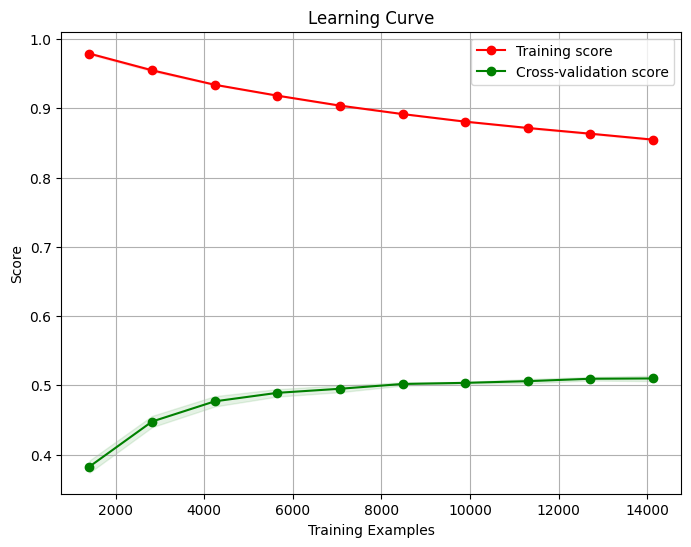

In [31]:
# Построим кривые обучения для полученной модели
mu.plot_learning_curve(estimator=pipeline_best_h, X=X_train, y=y_train_h, cv=3, scoring="f1_micro")

`Вывод по кривой обучения`
* Зазор между кривыми говорит о том, что модель переобучена: на тренировочных данных она показывает высокие результаты, но на отложенной выборке результаты хуже
* Увеличение количества данных же улучшает обобщающую способность модели, но не устраняет полностью разрыв с тренировочной кривой

### Рейтинг

In [21]:
# Optuna для поиска оптимальных гиперпараметров
def objective_rating(trial):    
    # Подбираем гиперпараметры TF-IDF
    tfidf_max_features = trial.suggest_int('preprocessor__text__tfidf__max_features', 10000, 20000, step=1000)
    tfidf_min_df = trial.suggest_int('preprocessor__text__tfidf__min_df', 1, 10)
    tfidf_max_df = trial.suggest_float('preprocessor__text__tfidf__max_df', 0.8, 1.0)

    text_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=tfidf_max_features,
            min_df=tfidf_min_df,
            max_df=tfidf_max_df))])

    num_pipe = Pipeline([('scaler', StandardScaler())])

    preprocessor = ColumnTransformer([
        ('text', text_pipe, text_col),
        ('num', num_pipe, num_cols)])

    # Подбираем гиперпараметры LGBMClassifier
    max_depth  = trial.suggest_int("clf__max_depth", 3, 12)
    learning_rate = trial.suggest_float('clf__learning_rate', 1e-3, 1e-1)
    n_estimators = trial.suggest_int('clf__n_estimators', 100, 1000)

    clf = LGBMClassifier(
        max_depth = max_depth,
        learning_rate = learning_rate,
        n_estimators = n_estimators,
        verbose = -1,
        n_jobs=7,
        random_state = 42)

    # Задаём модель
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', clf)])

    score = cross_val_score(pipeline, X_train, y_train_r, cv=3, scoring="f1_micro",  n_jobs=7).mean()
    return score


study_rating = optuna.create_study(direction="maximize")
study_rating.optimize(objective_rating, n_trials=1)

In [ ]:
# Сохраняем лучшие параметры для модели рейтинга
best_params_r = study_hubs.best_params
with open("best_params_r.pkl", "wb") as f:
    pickle.dump(best_params_r, f)
best_params_r

{'preprocessor__text__tfidf__max_features': 20000,
 'preprocessor__text__tfidf__min_df': 10,
 'preprocessor__text__tfidf__max_df': 0.9070462182751947,
 'clf__max_depth': 8,
 'clf__learning_rate': 0.07332512741088507,
 'clf__n_estimators': 157}

In [ ]:
# Снова поделим данные (чтобы не было ошибок)
X_train, X_test, y_train_r, y_test_r = train_test_split(X, y_rating, test_size=0.25)

# Лучший пайплайн для предсказания рейтинга статей
pipeline_best_r = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('text', Pipeline([('tfidf', TfidfVectorizer())]), text_col),
        ('num', Pipeline([('scaler', StandardScaler())]), num_cols) ])),
    ('clf', LGBMClassifier(verbose = -1, n_jobs=-1, random_state = 42))])

pipeline_best_r.set_params(**best_params_r)

pipeline_best_r.fit(X_train, y_train_r)
y_pred_r = pipeline_best_r.predict(X_test)

In [35]:
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r, y_pred_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.6347, 'Recall': 0.6347, 'F1-Score': 0.6347, 'Hamming Loss': 0.3653}
macro - {'Precision': 0.511, 'Recall': 0.4046, 'F1-Score': 0.411, 'Hamming Loss': 0.3653}
weighted - {'Precision': 0.6245, 'Recall': 0.6347, 'F1-Score': 0.6229, 'Hamming Loss': 0.3653}


`Выводы по метрикам после подбора гиперпараметров`
* Для микро-метрик значения Precision, Recall и F1-Score увеличились с 0.6058 до 0.6347, при учёте всех классов в совокупности модель стала давать более точные и сбалансированные предсказания
* Для макро-метрик Recall увеличился не так существенно (с 0.37 до 0.41), наблюдается значительный рост Precision (с 0.41 до 0.51) и F1-Score (с 0.37 до 0.41), то есть даже для редких классов модель с настройкой гиперпараметров показывает лучшие результаты
* Для взвешенных метрик так же видна позитивная динамика (Precision вырос с 0.0.6 до 0.63, Recall с 0.61 до 0.64 и F1-Score с 0.59 до 0.62) что подтверждает то, что модель стала лучше справляться с классами различной частоты, улучшив предсказания в совокупности
* Снижение Hamming Loss с 0.394 до 0.365 свидетельствует о том, что доля неверно предсказанных меток уменьшилась, это также позитив

c:\Users\dimas\anaconda3\envs\data_sc\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


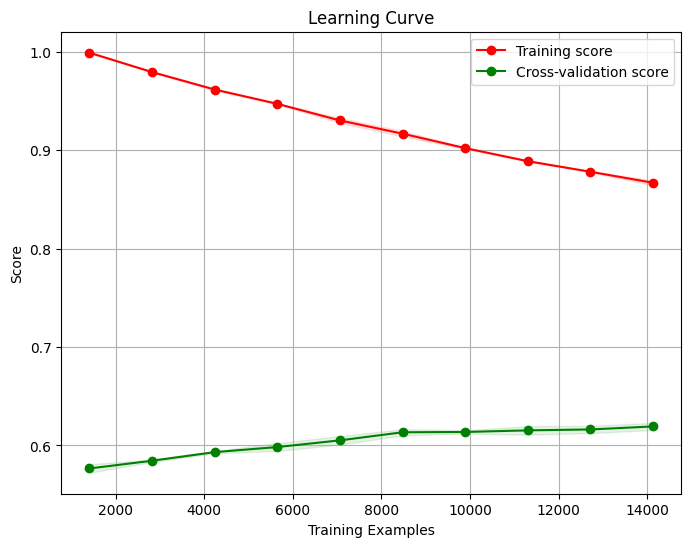

In [36]:
# Построим кривые обучения для полученной модели
mu.plot_learning_curve(estimator=pipeline_best_r, X=X_train, y=y_train_r, cv=3, scoring="f1_micro")

`Вывод по кривой обучения`
* Метрика F1-score (micro) для валидационной выборки изначально выше, начинается около 0.6 и продолжает расти ближе к 0.65
* Разрыв между обучающей и валидационной кривыми тоже есть, но он меньше, чем для модели предсказания хабов, обучающая кривая опускается примерно с 0.95 до 0.85, а валидационная поднимается и постепенно приближается
* Модель для рейтинга обобщается лучше (если смотреть на кривые), но она всё ещё переобучается (тренировочная метрика выше валидационной)

## Обучение моделей на полном наборе данных

### Предобработка данных

In [8]:
# Теперь обучим лучшие пайплайны на всём наборе данных
df = pd.read_parquet("df_l_fin.parquet")

# Выделение рейтинга статьи
df['rating_level'] = mu.categorize_ratings(df)

# Предобработка датасета: фильтрация, объединение текстовых токенов,
# кодировка меток(хабов) и преобразование рейтингов
(df_prepr, y_multi_reduced, selector, 
index_to_label, mlb, 
y_rating, inverse_rating_mapping) = mu.df_preprocess(df)

# Оставим только необходимые столбцы
X = df_prepr.drop(columns=['author', 'publication_date', 'url', 'text_pos_tags', 'hubs', 'rating_level', 'rating_new', 'hubs_encoded']).copy()

# Кодировка individ/company
X['individ/company'] = X['individ/company'].map({'individual':0, 'company':1})
X = X.rename(columns={'individ/company':'is_company'})

### Хабы

In [10]:
# Разделение на выборки, обучение и предикт
X_train, X_test, y_train_h, y_test_h = train_test_split(X, y_multi_reduced, test_size=0.25)
pipeline_best_h.fit(X_train, y_train_h)
y_pred_h = pipeline_best_h.predict(X_test)

In [42]:
# Сохранение модели для предсказания хабов (тем) статей
joblib.dump(pipeline_best_h, 'pipeline_h.pkl')

# Метрики
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_h, y_pred_h, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.3424, 'Recall': 0.7851, 'F1-Score': 0.4768, 'Hamming Loss': 0.0374}
macro - {'Precision': 0.3599, 'Recall': 0.7647, 'F1-Score': 0.4818, 'Hamming Loss': 0.0374}
weighted - {'Precision': 0.3755, 'Recall': 0.7851, 'F1-Score': 0.5006, 'Hamming Loss': 0.0374}


`Выводы`
* По сравнению моделью, обученной только на текстовых признаках, мы получили общее ухудшение всех метрик на несколько процентов
* Можно заметить, что про использовании всех признаков модель становится более чувствительной и пропускает меньше истинных тем (высокий Recall), однако за счёт этого качество предсказаний ухудшается из-за роста ложных срабатываний (низкий Precision) и увеличения числа ошибок (Hamming Loss)
* Если смотреть на наши целевые микро-метрики, то явно видно снижение Precision (с 0.38 до 0.34) и F1-Score (с 0.500 до 0.477), при этом Hamming Loss вырос с (0.0167 до 0.0374), единственный позитив это рост Recall (с 0.721 до 0.785)
* Таким образом для задачи предсказания тем статей более предпочтительной является модель, полученная на прошлом этапе базового бейзлайна (обученная только на текстовых признаках)

### Рейтинг

In [43]:
# Разделение на выборки, обучение и предикт
X_train, X_test, y_train_r, y_test_r = train_test_split(X, y_rating, test_size=0.25)
pipeline_best_r.fit(X_train, y_train_r)
y_pred_r = pipeline_best_r.predict(X_test)

In [44]:
# Сохранение модели для предсказания хабов (тем) статей
joblib.dump(pipeline_best_r, 'pipeline_r.pkl')

for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r, y_pred_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.6497, 'Recall': 0.6497, 'F1-Score': 0.6497, 'Hamming Loss': 0.3503}
macro - {'Precision': 0.6049, 'Recall': 0.4126, 'F1-Score': 0.4225, 'Hamming Loss': 0.3503}
weighted - {'Precision': 0.65, 'Recall': 0.6497, 'F1-Score': 0.6367, 'Hamming Loss': 0.3503}


`Выводы`
* Для модели LGBMClassifier с подобранными гиперпараметрами и всеми признаками наблюдается существенный рост всех метрик (микро-F1-score вырос с 0.496 до 0.65, макро-F1-score вырос с 0.288 до 0.4225, взвешенный F1-score вырос с 0.5173 до 0.6367, Hamming Loss уменьшился с 0.504 до 0.3503)
* Добавление признаков явно помогает модели лучше дифференцировать статьи по рейтингу, однако перекос в качестве по разным классам (разница между макро- и микро-F1-score) остаётся